In [1]:
import numpy as np
import pandas as pd
import time
import pickle


from joblib import dump, load
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

pd.options.display.float_format = '{:20,.15f}'.format

In [2]:
from importlib import reload
# module references for reload
import process_class, output, run_models

from process_class import Process
from output import output_metrics
from run_models import run_nn, run_lgb

reload(process_class)
reload(output)
reload(run_models)

# reimport in case changed
from process_class import Process
from output import output_metrics
from run_models import run_nn, run_lgb

In [3]:
full_raw = shuffle(pd.read_csv(f'datasets/dataset_all.csv'), random_state=0)

feature_sets = load('feature_sets.joblib')

with open('processed/dataset_all_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open('processed/dataset_all_process.pickle', 'rb') as handle:
    process = pickle.load(handle)

X = pd.concat([data['X_train'], data['X_test'], data['X_val']])
y = np.concatenate([data['y_train'], data['y_test'], data['y_val']])
X = X[feature_sets[2]]

with open('processed/dataset_all_no_process_data.pickle', 'rb') as handle:
    raw_data = pickle.load(handle)
X_raw = pd.concat([raw_data['X_train'], raw_data['X_test'], raw_data['X_val']])
y_raw = pd.concat([raw_data['y_train'], raw_data['y_test'], raw_data['y_val']])
X_raw = X_raw[feature_sets[2]]

In [4]:
cv_results = []

split_num=0
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X, y):
    split_num+=1
    print('###################################')
    print(f'{split_num}:\tsplit num')
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    data_part = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    cv_results.append((run_nn(data_part, process, with_val=False), data_part))

In [109]:
for metric in ['smape', 'mape', 'mae', 'rmse', 'adj_r2']:
    print(np.mean([cv_results[i][0][0]['test'][metric] for i in range(10)]))

81.0005169305043
778.262245592468
41670831.5
99801069.1
0.4860886432172409


In [ ]:
cv10_nn_wo_model = [(cv_results[i][0][0], cv_results[i][1]['X_test']) for i in range(10)]
dump(cv10_nn_wo_model, 'cv10_nn.joblib')

In [5]:
cv_nn = load('cv10_nn.joblib')

all_movies = pd.DataFrame(columns=full_raw.columns)
X_train_ = pd.DataFrame(columns=cv_nn[0][1].columns)
all_test_a = []
all_test_p = []
for i in range(10):
    batch_df = full_raw.loc[cv_nn[i][1].index, :]
    all_movies = pd.concat([all_movies, batch_df])
    X_train_ = pd.concat([X_train_, cv_nn[i][1]])
    all_test_a.extend(cv_nn[i][0]['result'][2])
    all_test_p.extend(cv_nn[i][0]['result'][3])

In [6]:
A = np.array(all_test_a)
P = np.array(all_test_p)

mape_list = 100*np.abs((A - P)/A)
mae_list = np.absolute(A - P)

movies = []
for i in range(len(A)):
    movies.append({
        'movie': all_movies.iloc[[i], :].to_dict(orient='index'),
        'predicted': P[i],
        'actual': A[i],
        'mape': mape_list[i],
        'mae': mae_list[i],
    })

In [7]:
sorted_mape = sorted(movies, key=lambda m: m['mape'], reverse=True)
sorted_mae = sorted(movies, key=lambda m: m['mae'], reverse=True)

dump(sorted_mape, 'sorted_mape_nn.joblib')
dump(sorted_mae, 'sorted_mae_nn.joblib')

['sorted_mae_nn.joblib']

In [8]:
bad_mape_index = [list(sorted_mape[i]['movie'].keys())[0] for i in range(100)]
bad_mae_index = [list(sorted_mae[i]['movie'].keys())[0] for i in range(100)]

In [9]:
for i in range(10):
    print('=================')
    movie = sorted_mape[i]
    movie_index = list(movie['movie'].keys())[0]
    movie_dict = movie['movie'][movie_index]
    print(f"index\t{movie_index}")
    print(f"title\t{movie_dict['META__title']}")
    print(f"revenue\t{movie_dict['META__revenue']}")
    print(f"budget\t{movie_dict['budget']}")
    print(f"predicted\t{movie['predicted']}")
    print(f"actual\t{movie['actual']}")
    print(f"mape\t{movie['mape']}")
    print(f"mae\t{movie['mae']}")

index	3837
title	The Room
revenue	1800
budget	6000000
predicted	6518502.0
actual	1800.0
mape	362039.0
mae	6516702.0
index	5642
title	Philadelphia Experiment II
revenue	2970
budget	5000000
predicted	5489262.0
actual	2970.0
mape	184723.63636363635
mae	5486292.0
index	6021
title	The Sacrament
revenue	9221
budget	4000000
predicted	16563665.0
actual	9221.0
mape	179529.8123847739
mae	16554444.0
index	3554
title	The Perfect Circle
revenue	1000
budget	1000
predicted	1683464.0
actual	1000.0
mape	168246.4
mae	1682464.0
index	3285
title	Fishtales
revenue	9216
budget	14000000
predicted	12208473.0
actual	9216.0
mape	132370.41015625
mae	12199257.0
index	3725
title	Foodfight!
revenue	73706
budget	65000000
predicted	80301592.0
actual	73706.0
mape	108848.51436789407
mae	80227886.0
index	5327
title	Area 51
revenue	7556
budget	5000000
predicted	7515991.0
actual	7556.0
mape	99370.50026469032
mae	7508435.0
index	505
title	City Lights
revenue	19181
budget	1500000
predicted	17663120.0
actual	19181.0
mape	919

In [10]:
for i in range(10):
    print('=================')
    movie = sorted_mae[i]
    movie_index = list(movie['movie'].keys())[0]
    movie_dict = movie['movie'][movie_index]
    print(f"index\t{movie_index}")
    print(f"title\t{movie_dict['META__title']}")
    print(f"revenue\t{movie_dict['META__revenue']}")
    print(f"budget\t{movie_dict['budget']}")
    print(f"predicted\t{movie['predicted']}")
    print(f"actual\t{movie['actual']}")
    print(f"mape\t{movie['mape']}")
    print(f"mae\t{movie['mae']}")

index	3989
title	Avatar
revenue	2787965087
budget	237000000
predicted	743898432.0
actual	2787965087.0
mape	73.31751263784746
mae	2044066655.0
index	6890
title	Avengers: Endgame
revenue	2797800564
budget	356000000
predicted	1093104000.0
actual	2797800564.0
mape	60.92988134804022
mae	1704696564.0
index	320
title	Titanic
revenue	1845034188
budget	200000000
predicted	439773376.0
actual	1845034188.0
mape	76.16448633525266
mae	1405260812.0
index	4616
title	Star Wars: The Force Awakens
revenue	2068223624
budget	245000000
predicted	663310976.0
actual	2068223624.0
mape	67.92846922823854
mae	1404912648.0
index	4583
title	Jurassic World
revenue	1671713208
budget	150000000
predicted	428131456.0
actual	1671713208.0
mape	74.38965882717366
mae	1243581752.0
index	6891
title	Avengers: Infinity War
revenue	2046239637
budget	300000000
predicted	895192064.0
actual	2046239637.0
mape	56.25184617611823
mae	1151047573.0
index	7320
title	Furious 7
revenue	1506249360
budget	190000000
predicted	430888032.0
actua

In [11]:
cv_outliers = {}
for num_outliers in [50, 100, 250, 500]:
    print("#######################################################")
    print(num_outliers, "outliers")
    print("#######################################################")
    cv_outliers[num_outliers] = []
    bad_mape_index = [list(sorted_mape[i]['movie'].keys())[0] for i in range(num_outliers)]
    drop_positions = [i for i in range(X.shape[0]) if X.index.values[i] in bad_mape_index]

    X_outliers = X.copy()
    X_outliers.drop(bad_mape_index, inplace=True)
    y_outliers = y[[i for i in range(len(y)) if i not in drop_positions]]

    split_num=0
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X_outliers, y_outliers):
        split_num+=1
        print('###################################')
        print(f'{split_num}:\tsplit num')
        X_train, X_test = X_outliers.iloc[train_index, :], X_outliers.iloc[test_index, :]
        y_train, y_test = y_outliers[train_index], y_outliers[test_index]
        data_part = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
        cv_outliers[num_outliers].append((run_nn(data_part, process, with_val=False), data_part))

#######################################################
50 outliers
#######################################################
###################################
1:	split num


InternalError:  Blas GEMM launch failed : a.shape=(256, 195), b.shape=(195, 256), m=256, n=256, k=195
	 [[node sequential/dense/MatMul (defined at /home/stastempaccount/thesis/run_models.py:105) ]] [Op:__inference_train_function_1048]

Function call stack:
train_function


In [12]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

RuntimeError: Physical devices cannot be modified after being initialized

###################################
1:	split num
Epoch 00126: early stopping
-----------------------------------------------
output NN
train
smape: 78.959
mape: 845.363
mae: 40,647,226.000
rmse: 97,720,182.000
adj_r2: 0.635
test
smape: 81.534
mape: 984.654
mae: 36,842,995.000
rmse: 84,883,941.000
adj_r2: 0.581


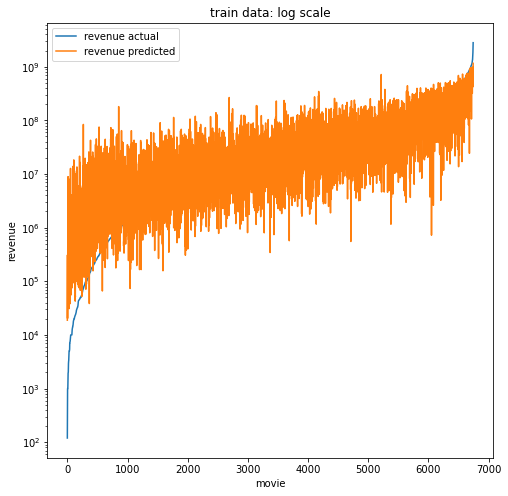

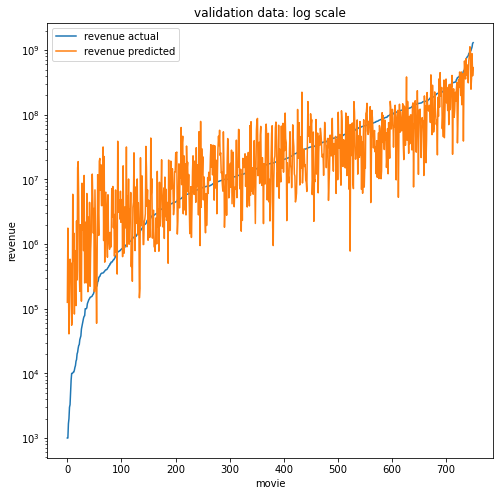

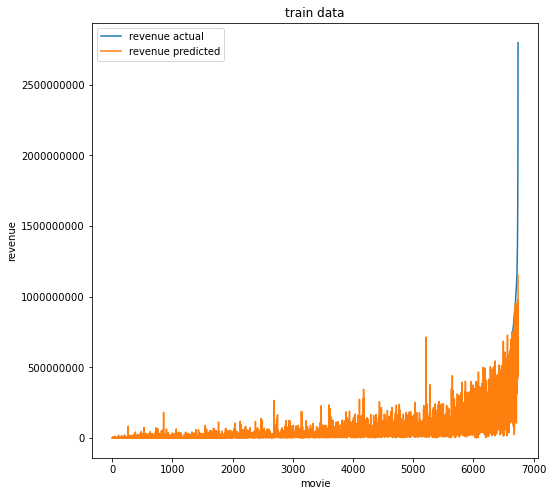

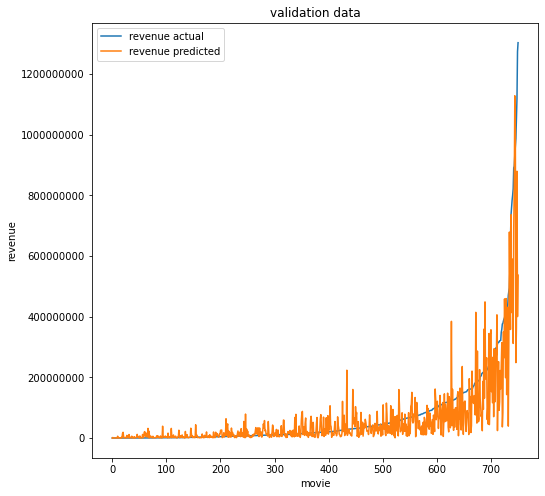

###################################
2:	split num
Epoch 00127: early stopping
-----------------------------------------------
output NN
train
smape: 81.414
mape: 633.061
mae: 42,275,718.000
rmse: 103,043,922.000
adj_r2: 0.568
test
smape: 84.369
mape: 625.301
mae: 46,638,618.000
rmse: 131,947,441.000
adj_r2: 0.376


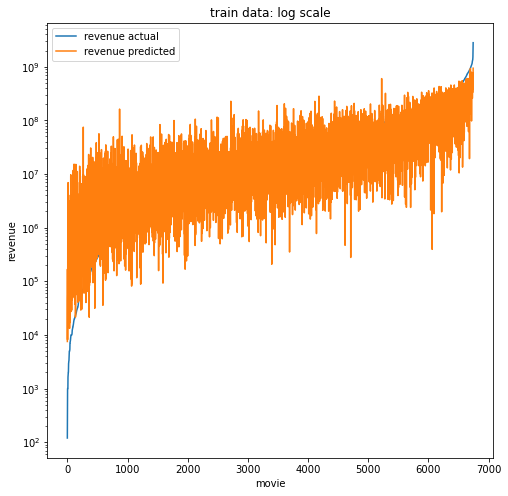

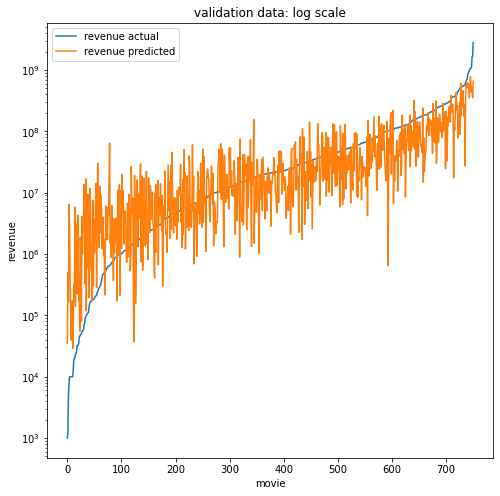

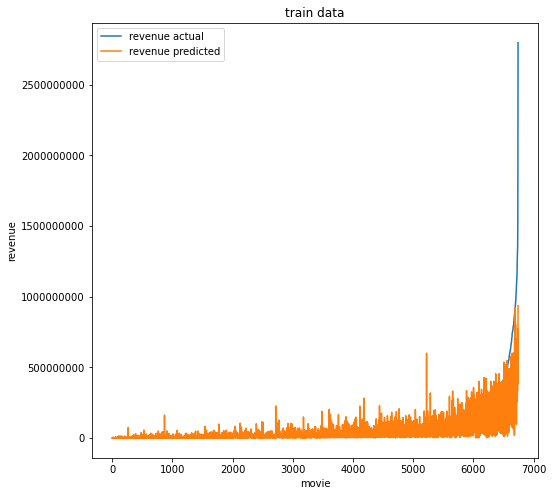

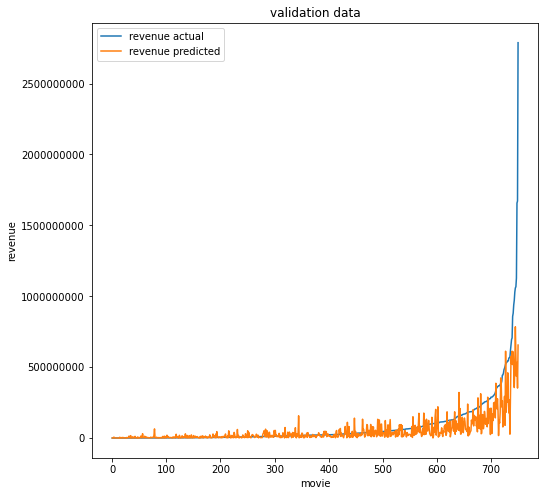

###################################
3:	split num
Epoch 00113: early stopping
-----------------------------------------------
output NN
train
smape: 78.927
mape: 915.378
mae: 40,282,308.000
rmse: 97,334,202.000
adj_r2: 0.644
test
smape: 81.196
mape: 1,138.555
mae: 40,121,583.000
rmse: 85,205,842.000
adj_r2: 0.492


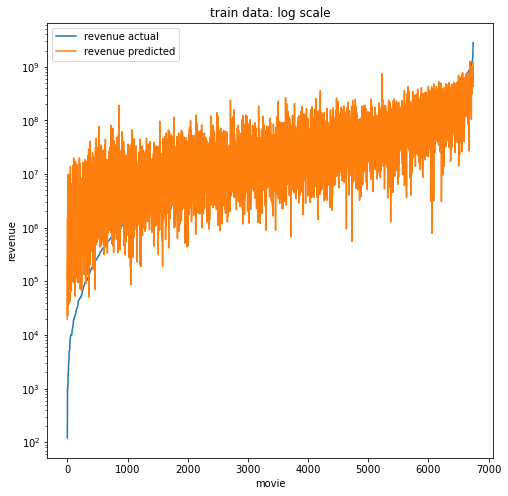

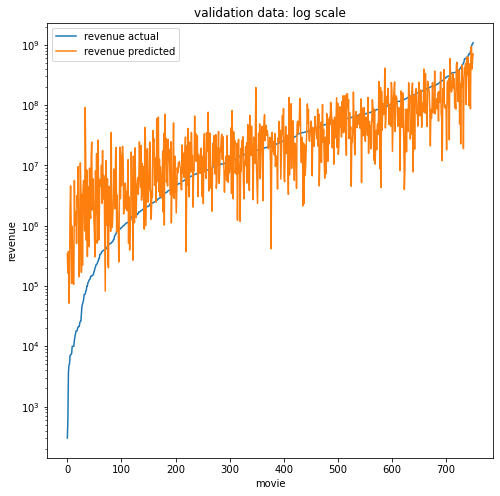

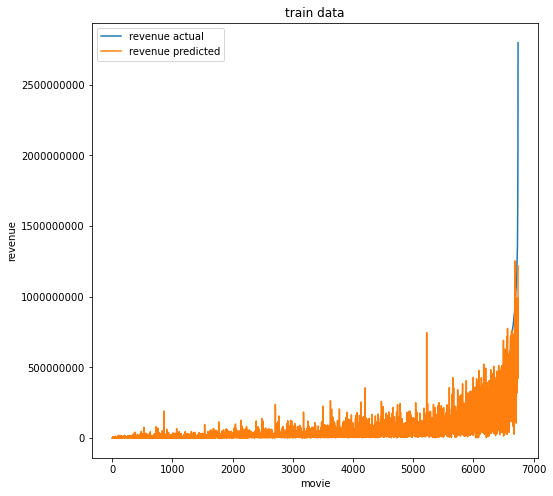

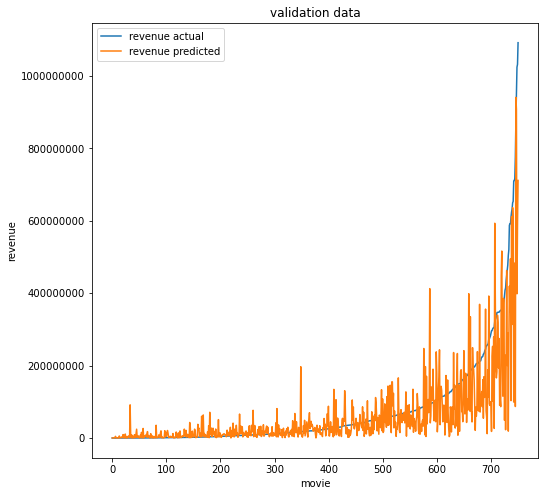

###################################
4:	split num
Epoch 00116: early stopping
-----------------------------------------------
output NN
train
smape: 79.352
mape: 822.975
mae: 40,274,934.000
rmse: 96,061,985.000
adj_r2: 0.642
test
smape: 78.652
mape: 762.480
mae: 39,438,064.000
rmse: 97,315,051.000
adj_r2: 0.522


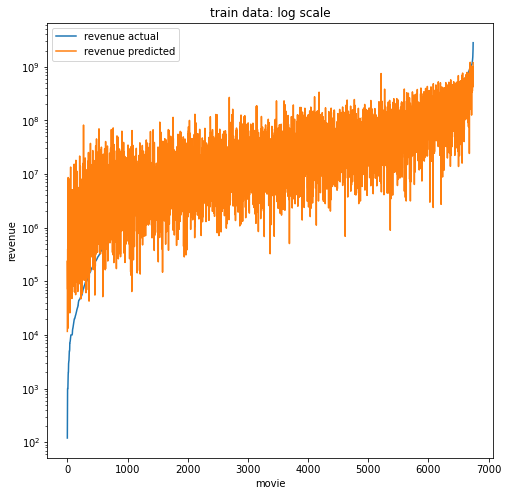

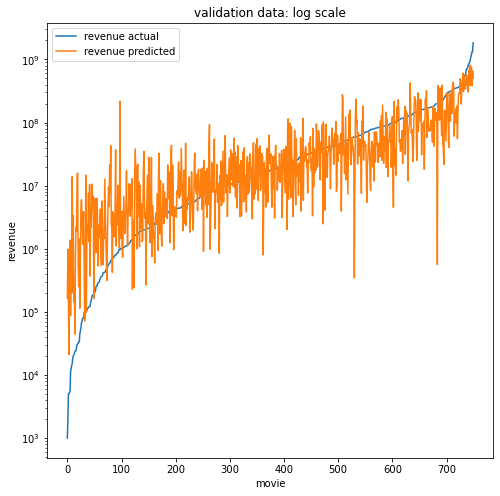

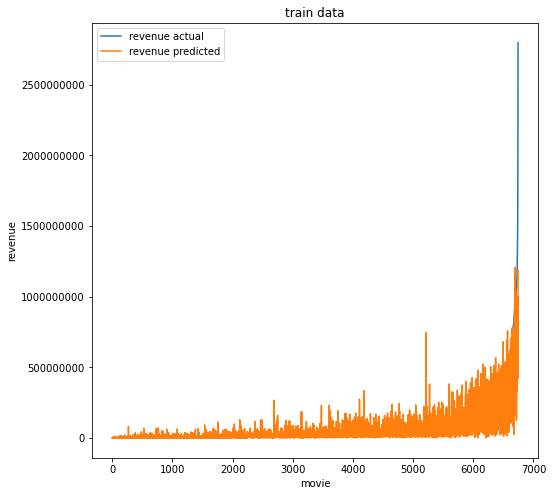

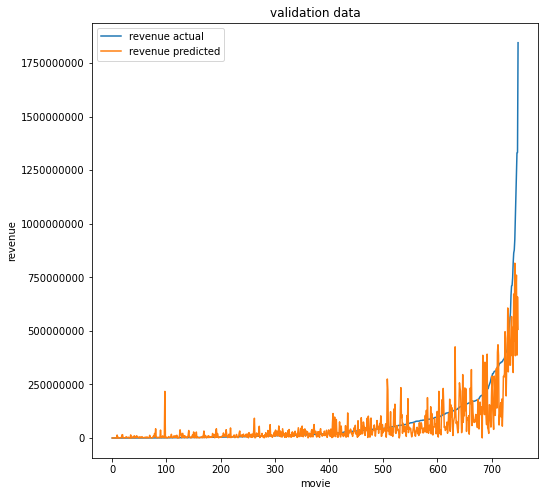

###################################
5:	split num
Epoch 00107: early stopping
-----------------------------------------------
output NN
train
smape: 80.568
mape: 757.767
mae: 41,121,918.000
rmse: 100,929,536.000
adj_r2: 0.584
test
smape: 83.613
mape: 429.867
mae: 52,782,143.000
rmse: 132,333,862.000
adj_r2: 0.382


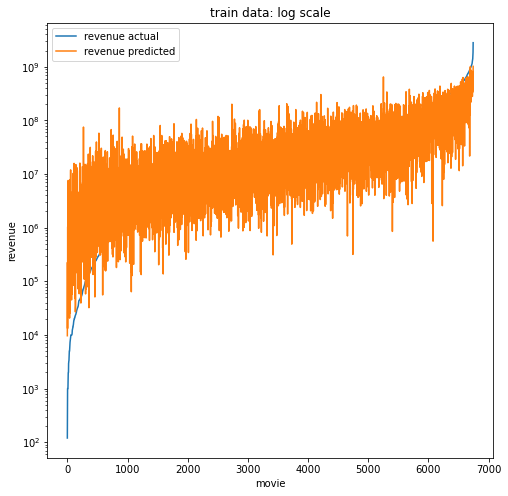

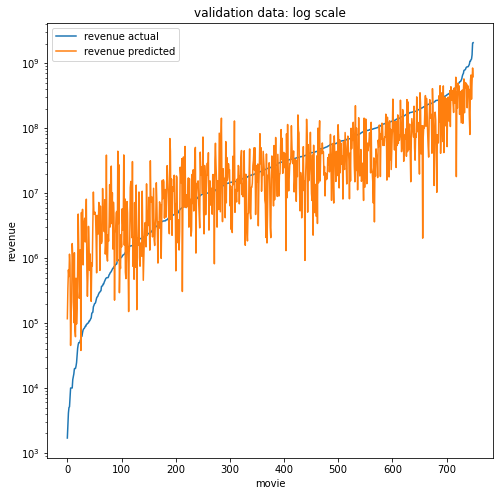

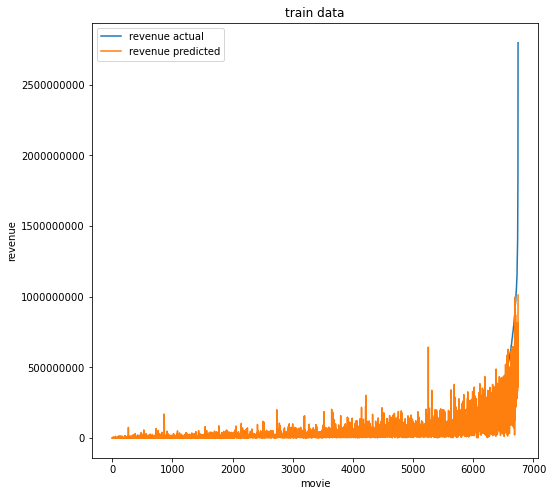

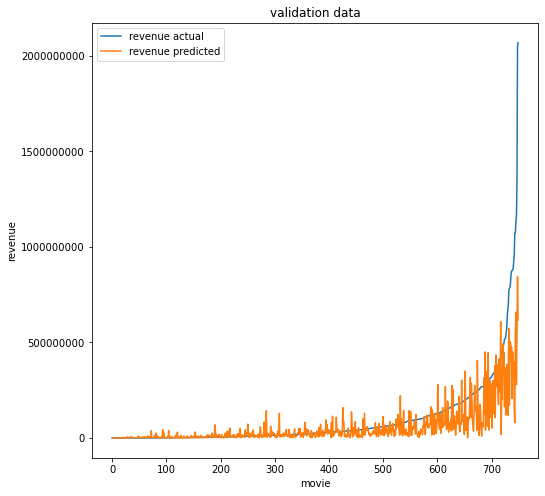

###################################
6:	split num
Epoch 00102: early stopping
-----------------------------------------------
output NN
train
smape: 80.167
mape: 692.067
mae: 41,301,200.000
rmse: 101,629,371.000
adj_r2: 0.609
test
smape: 79.993
mape: 1,141.356
mae: 40,298,826.000
rmse: 89,383,904.000
adj_r2: 0.483


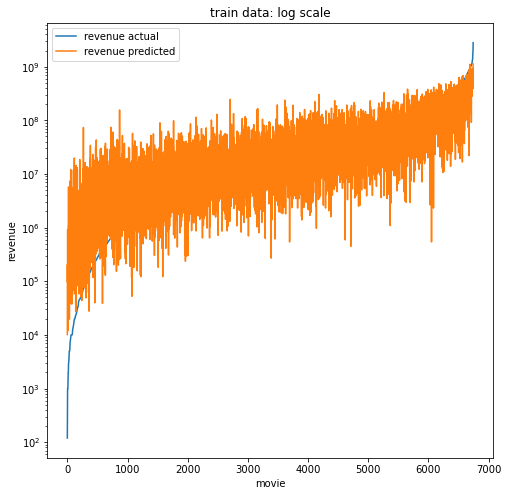

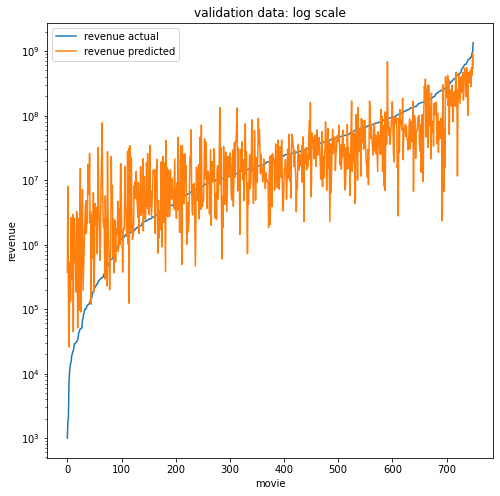

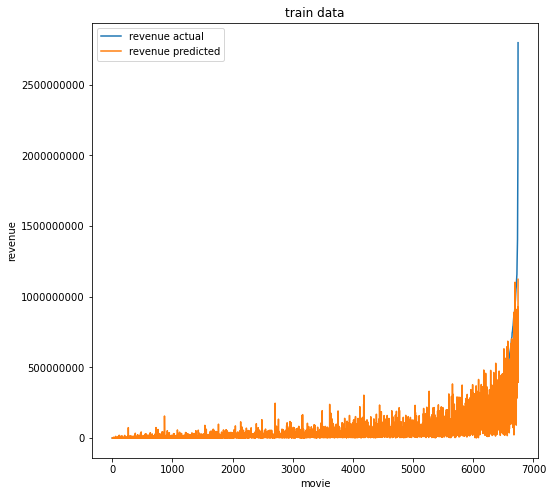

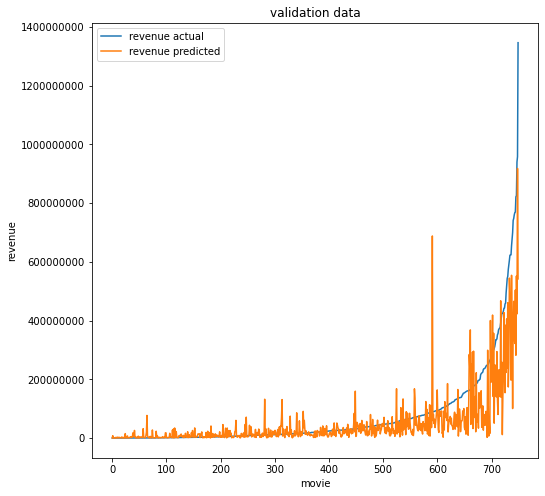

###################################
7:	split num
Epoch 00127: early stopping
-----------------------------------------------
output NN
train
smape: 79.604
mape: 853.082
mae: 41,207,840.000
rmse: 99,039,979.000
adj_r2: 0.614
test
smape: 79.683
mape: 473.327
mae: 40,150,736.000
rmse: 111,138,672.000
adj_r2: 0.453


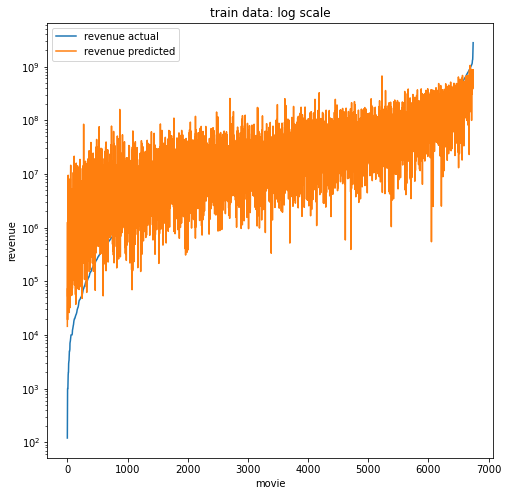

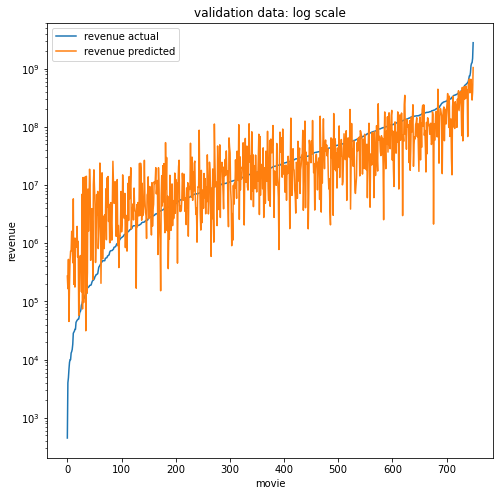

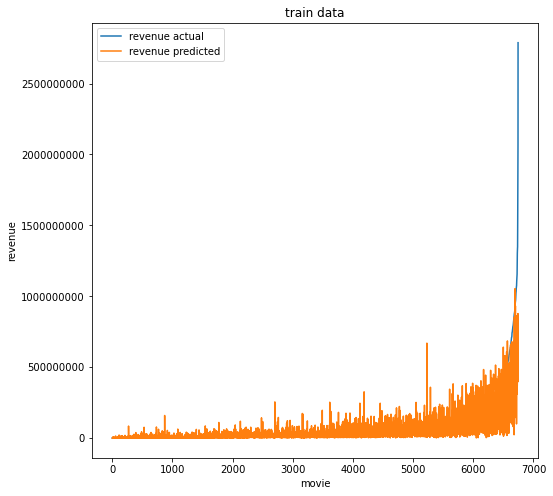

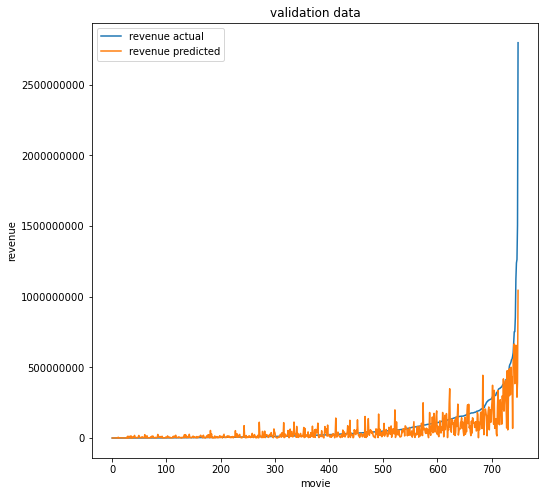

###################################
8:	split num
Epoch 00184: early stopping
-----------------------------------------------
output NN
train
smape: 78.837
mape: 802.782
mae: 39,955,526.000
rmse: 95,107,281.000
adj_r2: 0.656
test
smape: 79.258
mape: 1,195.052
mae: 37,170,439.000
rmse: 77,382,926.000
adj_r2: 0.636


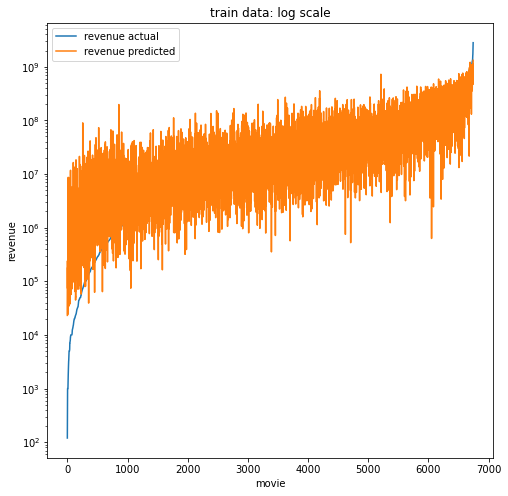

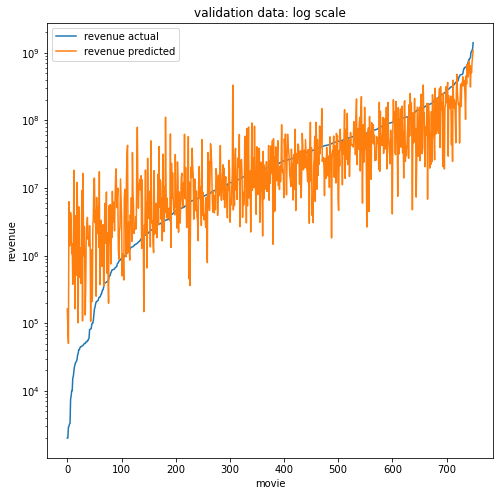

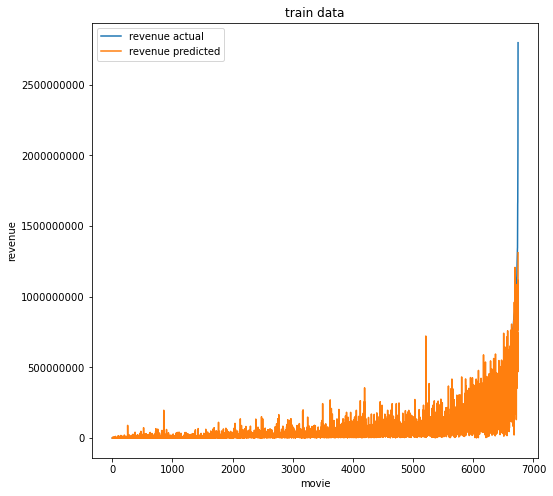

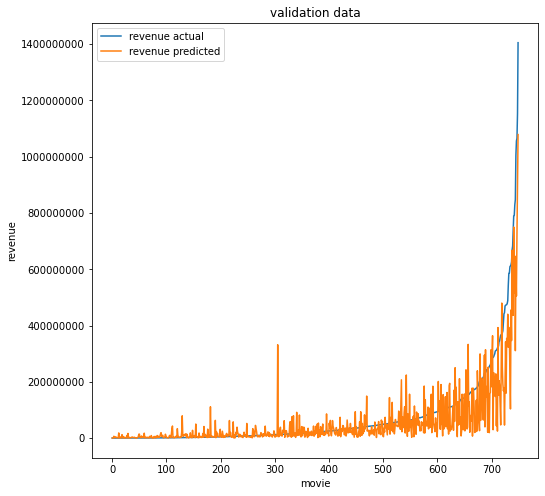

###################################
9:	split num
Epoch 00117: early stopping
-----------------------------------------------
output NN
train
smape: 80.263
mape: 743.107
mae: 41,684,181.000
rmse: 103,875,886.000
adj_r2: 0.585
test
smape: 79.382
mape: 988.196
mae: 42,925,034.000
rmse: 97,909,133.000
adj_r2: 0.481


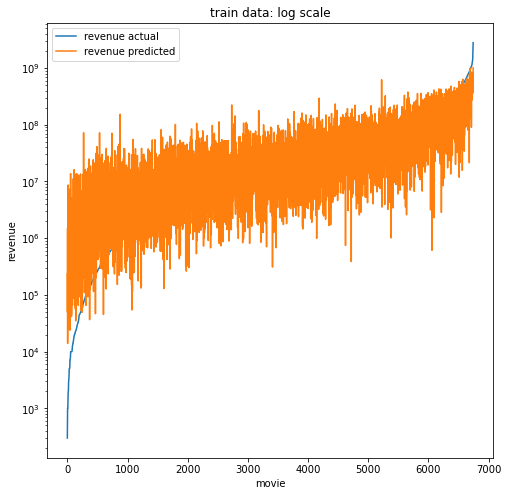

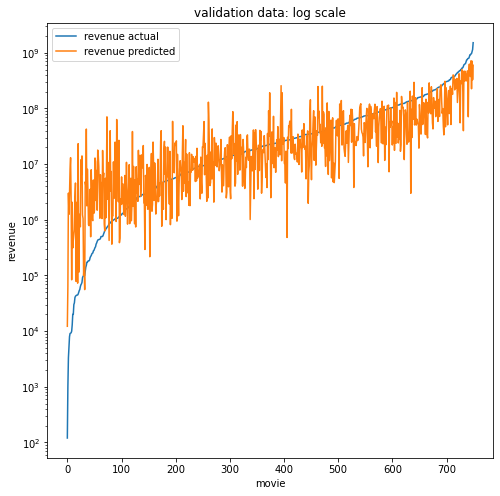

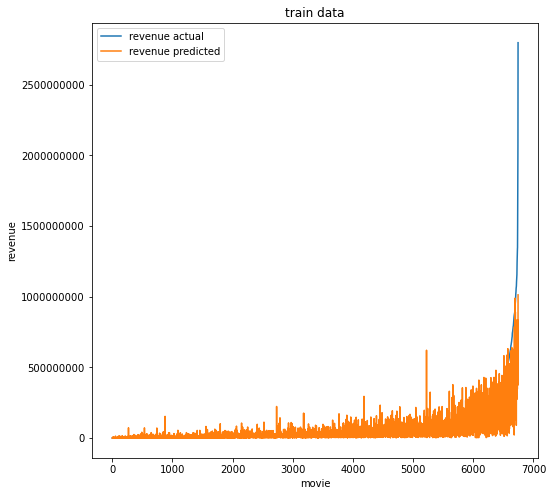

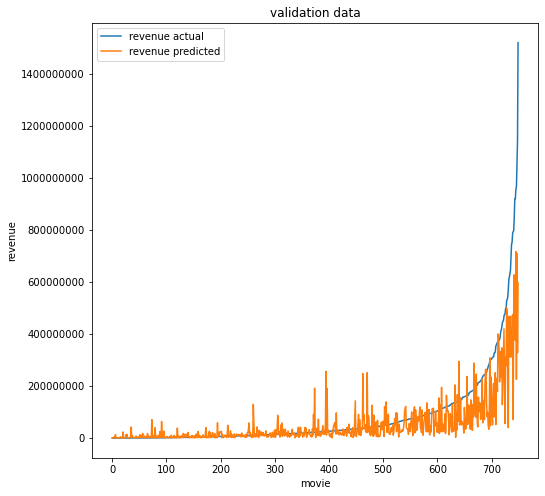

###################################
10:	split num
Epoch 00101: early stopping
-----------------------------------------------
output NN
train
smape: 79.301
mape: 782.051
mae: 40,214,959.000
rmse: 97,538,921.000
adj_r2: 0.639
test
smape: 80.995
mape: 665.041
mae: 41,997,409.000
rmse: 94,448,966.000
adj_r2: 0.434


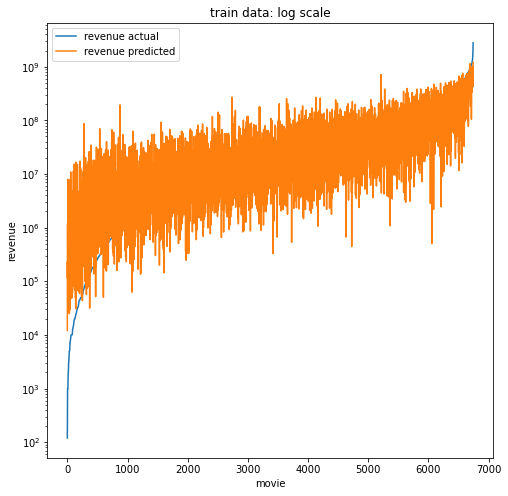

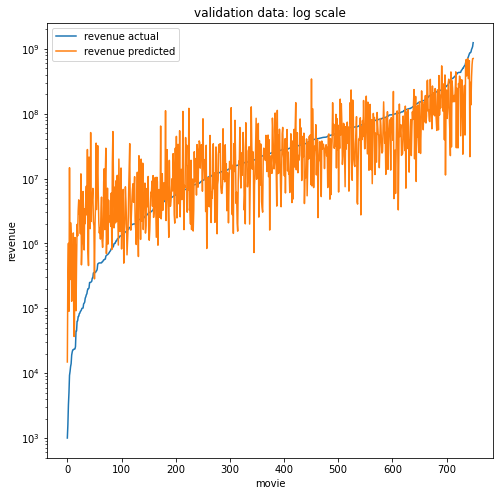

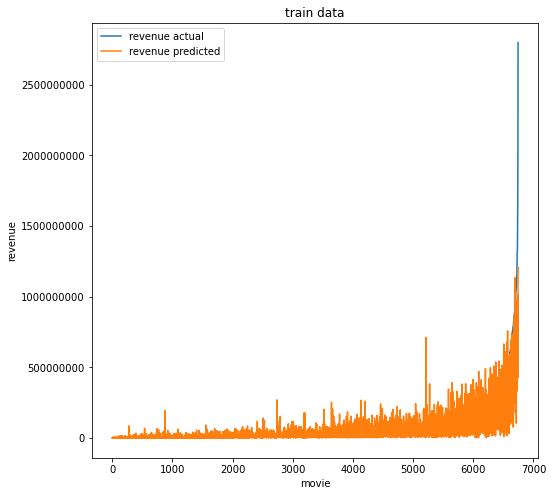

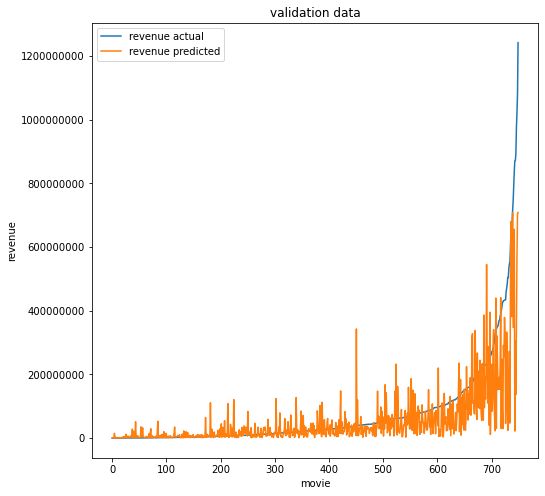

In [66]:
cv10_lgb_results = []

split_num=0
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X, y):
    split_num+=1
    print('###################################')
    print(f'{split_num}:\tsplit num')
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    data_part = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    cv10_lgb_results.append((run_nn(data_part, process, with_val=False), data_part))

In [68]:
for metric in ['smape', 'mape', 'mae', 'rmse', 'adj_r2']:
    print(np.mean([cv10_lgb_results[i][0]['test'][metric] for i in range(10)]))

80.8674970783687
840.3828405942328
41836584.7
100194973.8
0.4840395163327765


In [69]:
cv10_lgb_wo_model = [cv10_lgb_results[i][0] for i in range(10)]
dump(cv10_lgb_wo_model, 'cv10_lgb.joblib')

['cv10_lgb.joblib']